# Imports

In [ ]:
import pandas as pd
import numpy as np
import re
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, fbeta_score
import seaborn as sns
import matplotlib.pyplot as plt

# Loading & Preprocessing

In [ ]:
# --- Preprocessing Function ---
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'u\/\w+', '', text)  # Remove user mentions
    text = re.sub(r'r\/\w+', '', text)  # Remove subreddit mentions
    text = re.sub(r'http\S+', '', text)  # Remove links
    text = re.sub(r'\bfiller\b', '', text)  # Remove "filler"
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation/symbols
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize spaces
    return text

# --- Load & Preprocess Data ---
df = pd.read_csv('Suicide_Detection.csv', nrows=50000, engine='python')
df = df.dropna(subset=['text', 'class'])
df['label'] = df['class'].map({'non-suicide': 0, 'suicide': 1})
df['clean_text'] = df['text'].apply(preprocess_text)

# --- Split before vectorization ---
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)

# TF-IDF Vectorization

In [ ]:
# --- TF-IDF Vectorization ---
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

# USE Vectorization

In [ ]:
# --- USE Vectorization ---
print("Loading Universal Sentence Encoder...")
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def embed_text_batched(text_series, batch_size=512):
    embeddings = []
    for start in range(0, len(text_series), batch_size):
        batch = text_series.iloc[start:start + batch_size].tolist()
        embedded_batch = embed(batch).numpy()
        embeddings.append(embedded_batch)
        del embedded_batch  # free memory
        gc.collect()
    return np.vstack(embeddings)

X_train_use =  embed_text_batched(X_train_text, batch_size=256)
X_test_use = embed_text_batched(X_test_text, batch_size=256)

Loading Universal Sentence Encoder...


# SVM


📊 Evaluation (Threshold = 0.5):
              precision    recall  f1-score   support

 non-suicide       0.91      0.93      0.92      5006
     suicide       0.93      0.91      0.92      4994

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Recall: 0.9111
Precision: 0.9261
F2 Score: 0.9141


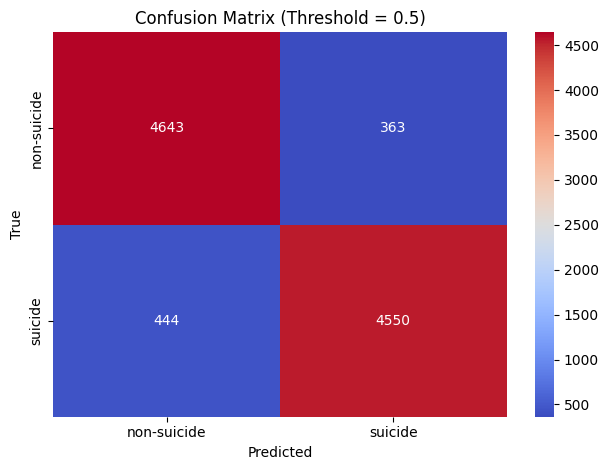


📊 Evaluation (Threshold = 0.3):
              precision    recall  f1-score   support

 non-suicide       0.95      0.86      0.90      5006
     suicide       0.87      0.95      0.91      4994

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Recall: 0.9529
Precision: 0.8700
F2 Score: 0.9351


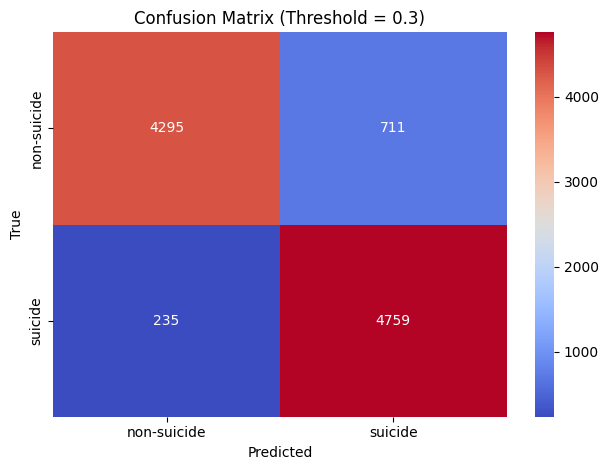

In [ ]:
# --- Train SVM ---
base_svm = LinearSVC(class_weight='balanced', random_state=42)
svm = CalibratedClassifierCV(base_svm, cv=3)
svm.fit(X_train_tfidf, y_train)

# --- Predict ---
y_proba = svm.predict_proba(X_test_tfidf)[:, 1]

for threshold in [0.5, 0.3]:
    y_pred = (y_proba > threshold).astype(int)
    print(f"\n📊 Evaluation (Threshold = {threshold}):")
    print(classification_report(y_test, y_pred, target_names=['non-suicide', 'suicide']))

    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)

    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F2 Score: {f2:.4f}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=['non-suicide', 'suicide'], yticklabels=['non-suicide', 'suicide'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix (Threshold = {threshold})")
    plt.tight_layout()
    plt.show()


📊 Evaluation (Threshold = 0.5):
              precision    recall  f1-score   support

 non-suicide       0.94      0.93      0.94      5006
     suicide       0.93      0.94      0.94      4994

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

Recall: 0.9395
Precision: 0.9339
F2 Score: 0.9384


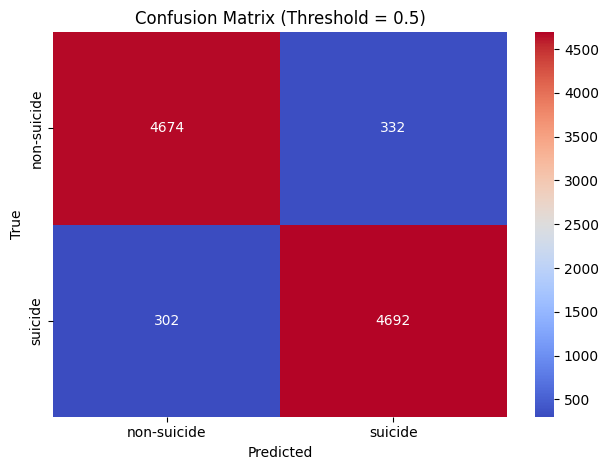


📊 Evaluation (Threshold = 0.3):
              precision    recall  f1-score   support

 non-suicide       0.96      0.90      0.93      5006
     suicide       0.90      0.97      0.93      4994

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

Recall: 0.9662
Precision: 0.9020
F2 Score: 0.9526


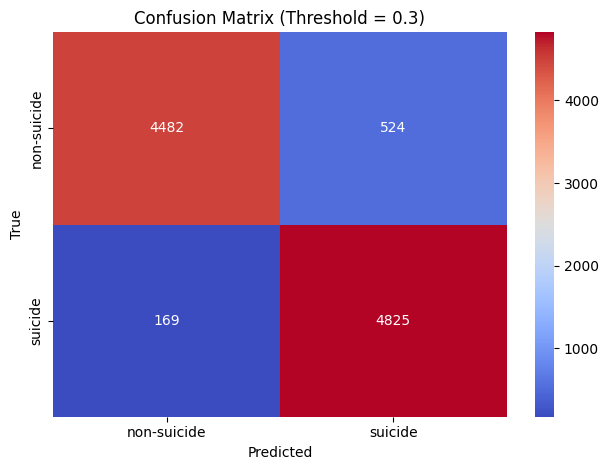

In [ ]:
# --- Train SVM ---
base_svm = LinearSVC(class_weight='balanced', random_state=42)
svm = CalibratedClassifierCV(base_svm, cv=3)
svm.fit(X_train_use, y_train)

# --- Predict ---
y_proba = svm.predict_proba(X_test_use)[:, 1]

for threshold in [0.5, 0.3]:
    y_pred = (y_proba > threshold).astype(int)
    print(f"\n📊 Evaluation (Threshold = {threshold}):")
    print(classification_report(y_test, y_pred, target_names=['non-suicide', 'suicide']))

    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)

    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F2 Score: {f2:.4f}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=['non-suicide', 'suicide'], yticklabels=['non-suicide', 'suicide'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix (Threshold = {threshold})")
    plt.tight_layout()
    plt.show()


# Random Forest


📊 Evaluation (Threshold = 0.5):
              precision    recall  f1-score   support

 non-suicide       0.86      0.88      0.87      5006
     suicide       0.88      0.86      0.87      4994

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Recall: 0.8618
Precision: 0.8782
F2 Score: 0.8651


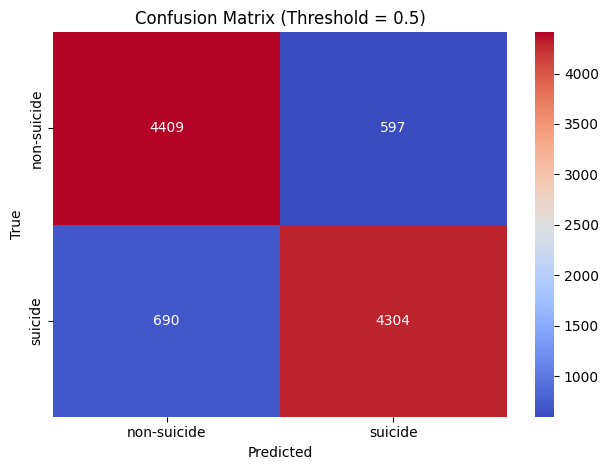


📊 Evaluation (Threshold = 0.3):
              precision    recall  f1-score   support

 non-suicide       0.92      0.77      0.84      5006
     suicide       0.80      0.94      0.86      4994

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000

Recall: 0.9351
Precision: 0.7992
F2 Score: 0.9044


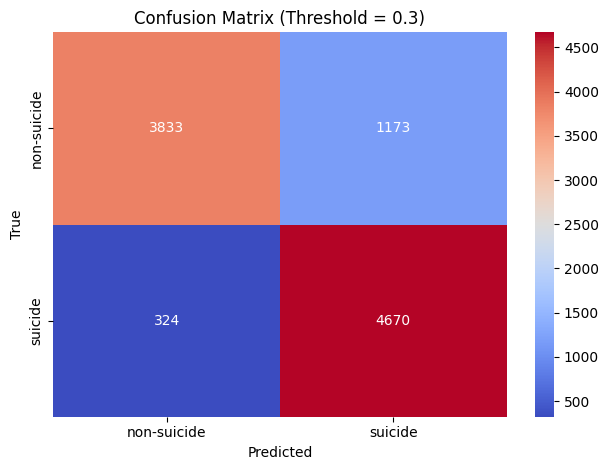

In [ ]:

# --- Random Forest Classifier ---
rf = RandomForestClassifier(
    n_estimators=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_tfidf, y_train)

# --- Predict ---
y_proba = rf.predict_proba(X_test_tfidf)[:, 1]

for threshold in [0.5, 0.3]:
    y_pred = (y_proba > threshold).astype(int)
    print(f"\n📊 Evaluation (Threshold = {threshold}):")
    print(classification_report(y_test, y_pred, target_names=['non-suicide', 'suicide']))

    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)

    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F2 Score: {f2:.4f}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=['non-suicide', 'suicide'], yticklabels=['non-suicide', 'suicide'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix (Threshold = {threshold})")
    plt.tight_layout()
    plt.show()


📊 Evaluation (Threshold = 0.5):
              precision    recall  f1-score   support

 non-suicide       0.88      0.94      0.91      5006
     suicide       0.93      0.87      0.90      4994

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000

Recall: 0.8722
Precision: 0.9312
F2 Score: 0.8834


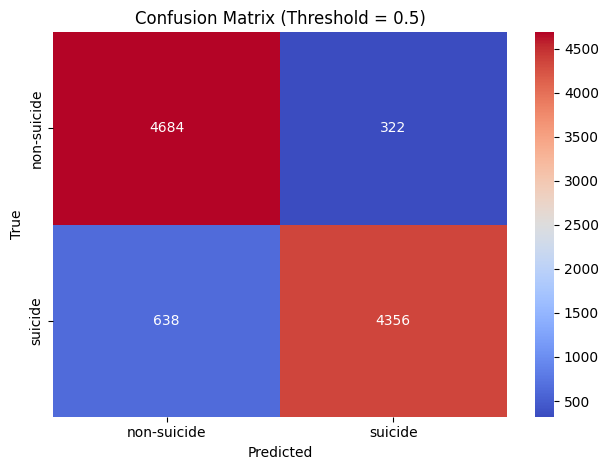


📊 Evaluation (Threshold = 0.3):
              precision    recall  f1-score   support

 non-suicide       0.94      0.86      0.89      5006
     suicide       0.87      0.94      0.90      4994

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Recall: 0.9421
Precision: 0.8665
F2 Score: 0.9260


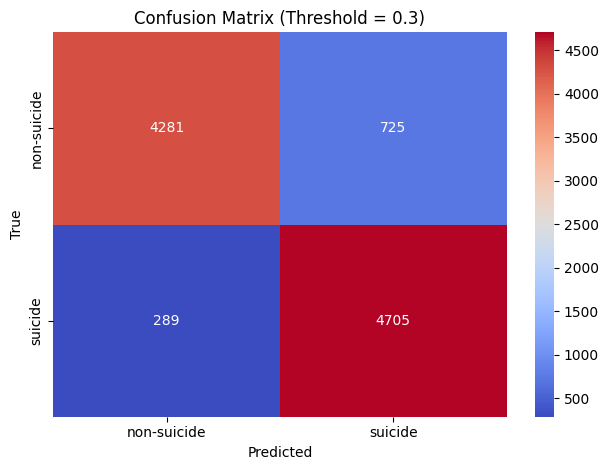

In [ ]:
# --- Random Forest Classifier ---
rf = RandomForestClassifier(
    n_estimators=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_use, y_train)

# --- Predict ---
y_proba = rf.predict_proba(X_test_use)[:, 1]

for threshold in [0.5, 0.3]:
    y_pred = (y_proba > threshold).astype(int)
    print(f"\n📊 Evaluation (Threshold = {threshold}):")
    print(classification_report(y_test, y_pred, target_names=['non-suicide', 'suicide']))

    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)

    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F2 Score: {f2:.4f}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=['non-suicide', 'suicide'], yticklabels=['non-suicide', 'suicide'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix (Threshold = {threshold})")
    plt.tight_layout()
    plt.show()

# Logistic Regression


📊 Evaluation (Threshold = 0.5):
              precision    recall  f1-score   support

 non-suicide       0.91      0.93      0.92      5006
     suicide       0.93      0.91      0.92      4994

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Recall: 0.9109
Precision: 0.9289
F2 Score: 0.9144


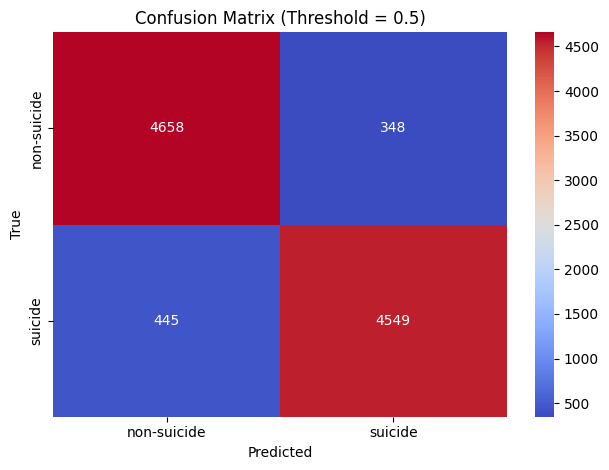


📊 Evaluation (Threshold = 0.3):
              precision    recall  f1-score   support

 non-suicide       0.95      0.86      0.90      5006
     suicide       0.87      0.96      0.91      4994

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Recall: 0.9573
Precision: 0.8690
F2 Score: 0.9383


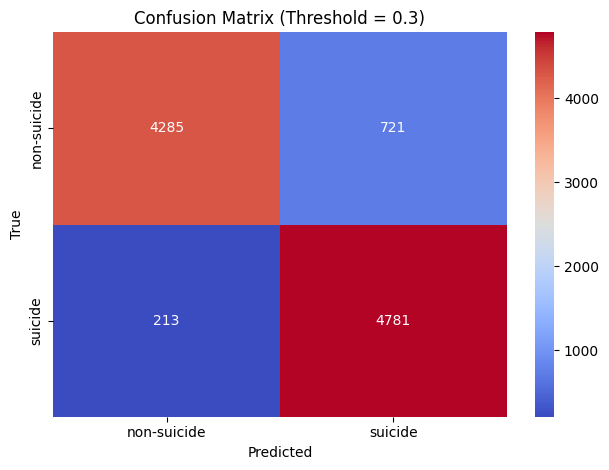

In [ ]:
# --- Logistic Regression ---
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logreg.fit(X_train_tfidf, y_train)

# --- Predict ---
y_proba = logreg.predict_proba(X_test_tfidf)[:, 1]

for threshold in [0.5, 0.3]:
    y_pred = (y_proba > threshold).astype(int)
    print(f"\n📊 Evaluation (Threshold = {threshold}):")
    print(classification_report(y_test, y_pred, target_names=['non-suicide', 'suicide']))

    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)

    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F2 Score: {f2:.4f}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=['non-suicide', 'suicide'], yticklabels=['non-suicide', 'suicide'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix (Threshold = {threshold})")
    plt.tight_layout()
    plt.show()


📊 Evaluation (Threshold = 0.5):
              precision    recall  f1-score   support

 non-suicide       0.94      0.94      0.94      5006
     suicide       0.94      0.94      0.94      4994

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

Recall: 0.9381
Precision: 0.9363
F2 Score: 0.9378


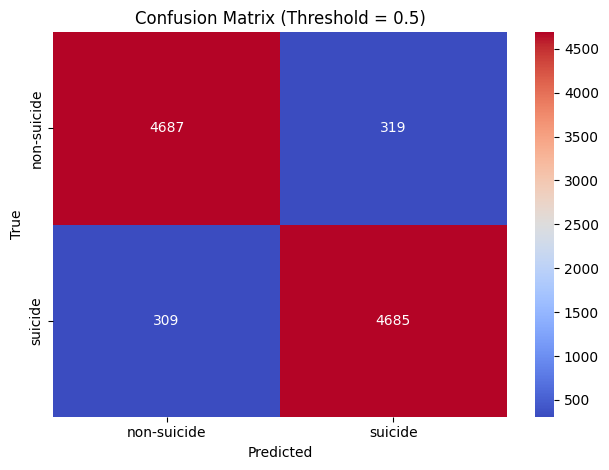


📊 Evaluation (Threshold = 0.3):
              precision    recall  f1-score   support

 non-suicide       0.96      0.89      0.93      5006
     suicide       0.90      0.97      0.93      4994

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

Recall: 0.9668
Precision: 0.9004
F2 Score: 0.9527


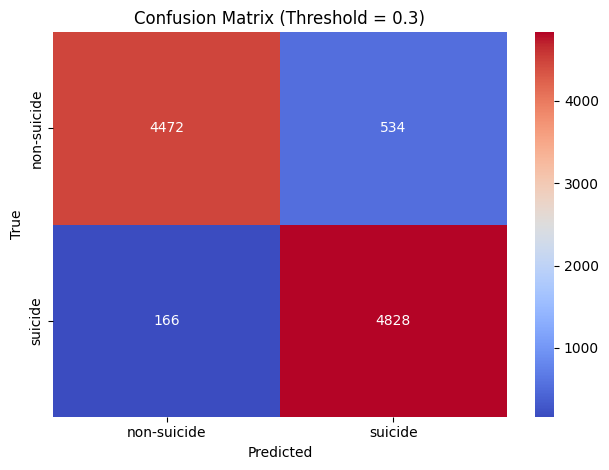

In [ ]:
# --- Logistic Regression ---
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logreg.fit(X_train_use, y_train)

# --- Predict ---
y_proba = logreg.predict_proba(X_test_use)[:, 1]

for threshold in [0.5, 0.3]:
    y_pred = (y_proba > threshold).astype(int)
    print(f"\n📊 Evaluation (Threshold = {threshold}):")
    print(classification_report(y_test, y_pred, target_names=['non-suicide', 'suicide']))

    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)

    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F2 Score: {f2:.4f}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=['non-suicide', 'suicide'], yticklabels=['non-suicide', 'suicide'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix (Threshold = {threshold})")
    plt.tight_layout()
    plt.show()

# CNN

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Multi-layered Dense model on TF-IDF data...
Epoch 1/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.8267 - loss: 0.3595 - val_accuracy: 0.9233 - val_loss: 0.1928
Epoch 2/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.9444 - loss: 0.1585 - val_accuracy: 0.9225 - val_loss: 0.2051
Epoch 3/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.9676 - loss: 0.0901 - val_accuracy: 0.9197 - val_loss: 0.2469
Epoch 4/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 24s 42ms/step - accuracy: 0.9860 - loss: 0.0407 - val_accuracy: 0.9162 - val_loss: 0.3416
Epoch 5/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.9945 - loss: 0.0168 - val_accuracy: 0.9185 - val_loss: 0.5938
Epoch 6/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - accuracy: 0.9961 - loss: 0.0096 - val_accuracy: 0.9150 - val_loss: 0.6151
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

📊 Multi-layered Dense Evaluation (Threshold = 0.5):
              precision    recall  f1-score   support

 non-suicide     

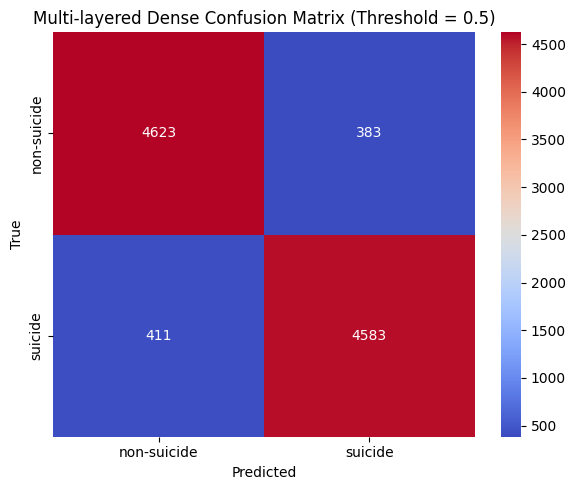


📊 Multi-layered Dense Evaluation (Threshold = 0.3):
              precision    recall  f1-score   support

 non-suicide       0.95      0.87      0.91      5006
     suicide       0.88      0.95      0.91      4994

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Recall: 0.9517
Precision: 0.8799
F2 Score: 0.9364


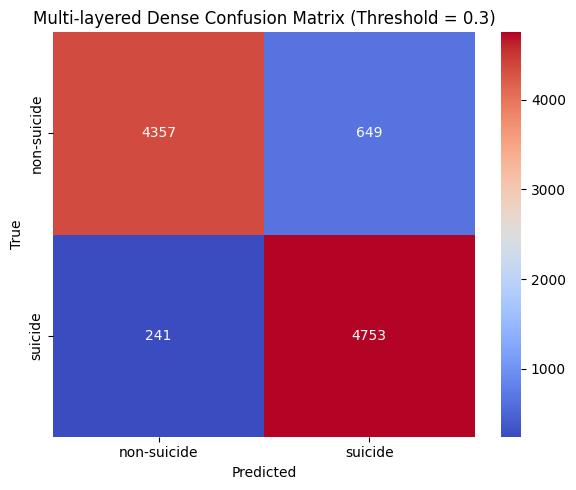

0

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Reshape TF-IDF data for CNN (needs shape [samples, time steps, features])
# We treat each TF-IDF feature as a time step for a single channel (feature dimension of 1)
# X_train_tfidf_cnn = X_train_tfidf.toarray().reshape(X_train_tfidf.shape[0], X_train_tfidf.shape[1], 1)
# X_test_tfidf_cnn = X_test_tfidf.toarray().reshape(X_test_tfidf.shape[0], X_test_tfidf.shape[1], 1)

# For Dense layers, we can use the flattened TF-IDF data
X_train_tfidf_flat = X_train_tfidf.toarray()
X_test_tfidf_flat = X_test_tfidf.toarray()


# Define the Multi-layered Dense model
dense_model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_tfidf_flat.shape[1],)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])


# Compile the model
dense_model.compile(optimizer=Adam(learning_rate=0.001), # Reduced learning rate for dense layers
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # Increased patience

# Train the model
print("\nTraining Multi-layered Dense model on TF-IDF data...")
history = dense_model.fit(X_train_tfidf_flat, y_train,
                        epochs=20, # Increased epochs
                        batch_size=64, # Increased batch size for faster training
                        validation_split=0.1,
                        callbacks=[early_stopping],
                        verbose=1)

# --- Predict ---
y_proba_dense = dense_model.predict(X_test_tfidf_flat).ravel() # Flatten the predictions

# --- Evaluate with different thresholds ---
for threshold in [0.5, 0.3]:
    y_pred_dense = (y_proba_dense > threshold).astype(int)
    print(f"\n📊 Multi-layered Dense Evaluation (Threshold = {threshold}):")
    print(classification_report(y_test, y_pred_dense, target_names=['non-suicide', 'suicide']))

    recall = recall_score(y_test, y_pred_dense)
    precision = precision_score(y_test, y_pred_dense)
    f2 = fbeta_score(y_test, y_pred_dense, beta=2)

    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F2 Score: {f2:.4f}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred_dense)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=['non-suicide', 'suicide'], yticklabels=['non-suicide', 'suicide'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Multi-layered Dense Confusion Matrix (Threshold = {threshold})")
    plt.tight_layout()
    plt.show()

# Clear session to free memory
tf.keras.backend.clear_session()
del dense_model
gc.collect()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Multi-layered Dense model on USE data...
Epoch 1/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8840 - loss: 0.2967 - val_accuracy: 0.9360 - val_loss: 0.1647
Epoch 2/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9405 - loss: 0.1655 - val_accuracy: 0.9385 - val_loss: 0.1598
Epoch 3/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9434 - loss: 0.1569 - val_accuracy: 0.9413 - val_loss: 0.1557
Epoch 4/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9497 - loss: 0.1374 - val_accuracy: 0.9408 - val_loss: 0.1615
Epoch 5/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9582 - loss: 0.1158 - val_accuracy: 0.9417 - val_loss: 0.1544
Epoch 6/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9634 - loss: 0.1046 - val_accuracy: 0.9408 - val_loss: 0.1633
Epoch 7/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9664 - loss: 0.0903 - val_accuracy: 0.9433 - val_loss: 0.1869
Epoch 8/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s

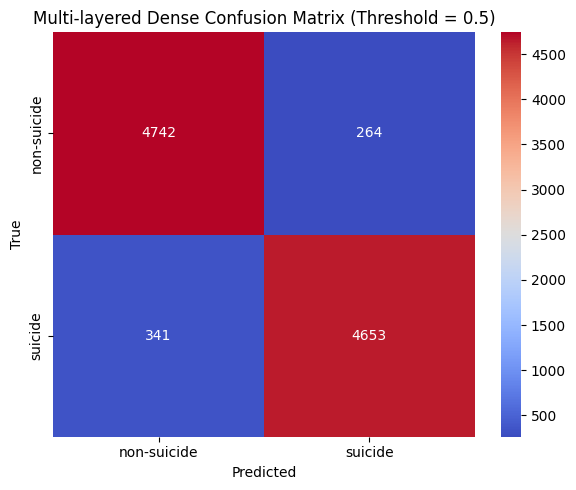


📊 Multi-layered Dense Evaluation (Threshold = 0.3):
              precision    recall  f1-score   support

 non-suicide       0.97      0.90      0.93      5006
     suicide       0.91      0.97      0.94      4994

    accuracy                           0.93     10000
   macro avg       0.94      0.93      0.93     10000
weighted avg       0.94      0.93      0.93     10000

Recall: 0.9680
Precision: 0.9061
F2 Score: 0.9549


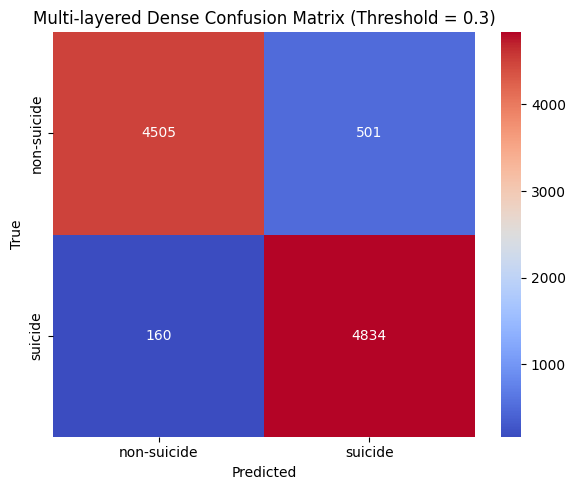

0

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Reshape USE data for CNN (needs shape [samples, time steps, features])
# We treat each USE feature as a time step for a single channel (feature dimension of 1)
# X_train_use_cnn = X_train_use.reshape(X_train_use.shape[0], X_train_use.shape[1], 1)
# X_test_use_cnn = X_test_use.reshape(X_test_use.shape[0], X_test_use.shape[1], 1)

# For Dense layers, we can use the USE embeddings directly as they are already 2D
X_train_use_flat = X_train_use
X_test_use_flat = X_test_use


# Define the Multi-layered Dense model
dense_model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_use_flat.shape[1],)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
dense_model.compile(optimizer=Adam(learning_rate=0.001), # Reduced learning rate for dense layers
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # Increased patience

# Train the model
print("\nTraining Multi-layered Dense model on USE data...")
history = dense_model.fit(X_train_use_flat, y_train,
                        epochs=20, # Increased epochs
                        batch_size=64, # Increased batch size for faster training
                        validation_split=0.1,
                        callbacks=[early_stopping],
                        verbose=1)

# --- Predict ---
y_proba_dense = dense_model.predict(X_test_use_flat).ravel() # Flatten the predictions

# --- Evaluate with different thresholds ---
for threshold in [0.5, 0.3]:
    y_pred_dense = (y_proba_dense > threshold).astype(int)
    print(f"\n📊 Multi-layered Dense Evaluation (Threshold = {threshold}):")
    print(classification_report(y_test, y_pred_dense, target_names=['non-suicide', 'suicide']))

    recall = recall_score(y_test, y_pred_dense)
    precision = precision_score(y_test, y_pred_dense)
    f2 = fbeta_score(y_test, y_pred_dense, beta=2)

    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F2 Score: {f2:.4f}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred_dense)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=['non-suicide', 'suicide'], yticklabels=['non-suicide', 'suicide'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Multi-layered Dense Confusion Matrix (Threshold = {threshold})")
    plt.tight_layout()
    plt.show()


# Clear session to free memory
tf.keras.backend.clear_session()
del dense_model
gc.collect()

# SVM + Gender

🧹 Filtered dataset size: 136740
gender
Male      123460
Female     13280
Name: count, dtype: int64

📊 Evaluation (Threshold = 0.5):
              precision    recall  f1-score   support

 non-suicide       0.91      0.91      0.91     10033
     suicide       0.95      0.95      0.95     17315

    accuracy                           0.94     27348
   macro avg       0.93      0.93      0.93     27348
weighted avg       0.94      0.94      0.94     27348

Recall: 0.9493
Precision: 0.9495
F2 Score: 0.9493


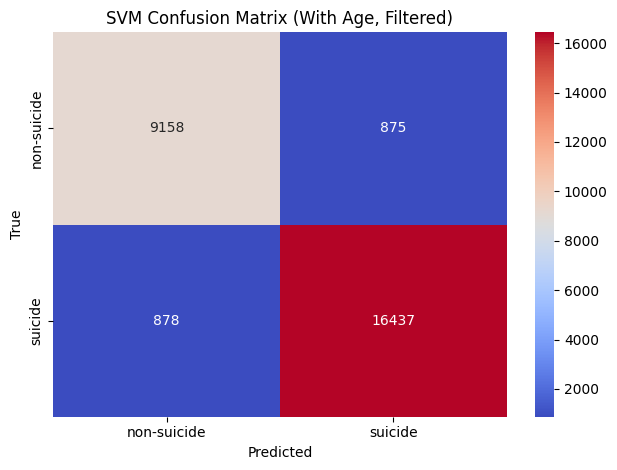


📊 Evaluation (Threshold = 0.3):
              precision    recall  f1-score   support

 non-suicide       0.95      0.85      0.90     10033
     suicide       0.92      0.98      0.95     17315

    accuracy                           0.93     27348
   macro avg       0.94      0.91      0.92     27348
weighted avg       0.93      0.93      0.93     27348

Recall: 0.9761
Precision: 0.9178
F2 Score: 0.9639


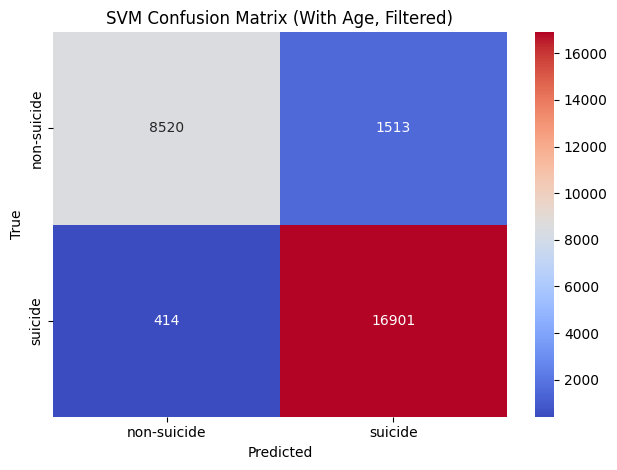

In [ ]:
# --- Imports ---
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, recall_score, precision_score, fbeta_score, confusion_matrix
from scipy.sparse import hstack, csr_matrix

# --- Gender Detection Function ---
def detect_gender(text):
    text = str(text).lower()

    male_keywords = r'\b(m|male|man|boy|he|him|his|guy|dude|gentleman|mr|sir|manly|masculine|boyish|masculinity|trans man|ftm|transmale|amab|assigned male)\b'
    female_keywords = r'\b(f|female|woman|girl|she|her|hers|lady|miss|ms|mrs|ma\'am|feminine|womanly|girly|femininity|trans woman|mtf|transfemale|afab|assigned female)\b'

    if re.search(male_keywords, text):
        return 'Male'
    elif re.search(female_keywords, text):
        return 'Female'
    return 'Unknown'

# --- Load and Filter Data ---
df = pd.read_csv('Suicide_Detection.csv', engine='python')
df = df.dropna(subset=['text', 'class'])
df['text'] = df['text'].str.replace(r'\bfiller\b', '', case=False, regex=True)

# Extract age and gender
df['gender'] = df['text'].apply(detect_gender)

# Filter out unknown gender
df = df[(df['gender'] != 'Unknown')].copy()
df['label'] = df['class'].map({'non-suicide': 0, 'suicide': 1})

print(f"🧹 Filtered dataset size: {len(df)}")
print(df['gender'].value_counts())

# --- Feature Engineering: Gender ---
gender_encoded = pd.get_dummies(df['gender'], prefix='gender')

# --- TF-IDF on Text ---
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_tfidf = tfidf.fit_transform(df['text'])

# --- Combine Features ---
X_meta = np.hstack([
    gender_encoded.values
])
X_combined = hstack([X_tfidf, csr_matrix(X_meta)])
y = df['label'].values

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, stratify=y, random_state=42)

# --- Train SVM with Calibration ---
base_svm = LinearSVC(class_weight='balanced', random_state=42)
svm = CalibratedClassifierCV(base_svm, cv=3)
svm.fit(X_train, y_train)

# --- Predict Probabilities and Apply Threshold ---
y_proba = svm.predict_proba(X_test)[:, 1]
threshold = 0.5
y_pred = (y_proba > threshold).astype(int)

# --- Evaluation ---
print(f"\n📊 Evaluation (Threshold = {threshold}):")
print(classification_report(y_test, y_pred, target_names=['non-suicide', 'suicide']))

recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2)

print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F2 Score: {f2:.4f}")

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=['non-suicide', 'suicide'], yticklabels=['non-suicide', 'suicide'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SVM Confusion Matrix (With Age, Filtered)")
plt.tight_layout()
plt.show()


# --- Predict Probabilities and Apply Threshold ---
y_proba = svm.predict_proba(X_test)[:, 1]
threshold = 0.3
y_pred = (y_proba > threshold).astype(int)

# --- Evaluation ---
print(f"\n📊 Evaluation (Threshold = {threshold}):")
print(classification_report(y_test, y_pred, target_names=['non-suicide', 'suicide']))

recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2)

print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F2 Score: {f2:.4f}")

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=['non-suicide', 'suicide'], yticklabels=['non-suicide', 'suicide'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SVM Confusion Matrix (With Age, Filtered)")
plt.tight_layout()
plt.show()

🧹 Filtered dataset size: 136740
gender
Male      123460
Female     13280
Name: count, dtype: int64
📦 Loading Universal Sentence Encoder...
🧠 Embedding training text...
🧠 Embedding test text...

📊 Evaluation (Threshold = 0.5):
              precision    recall  f1-score   support

 non-suicide       0.93      0.92      0.92     10033
     suicide       0.95      0.96      0.96     17315

    accuracy                           0.94     27348
   macro avg       0.94      0.94      0.94     27348
weighted avg       0.94      0.94      0.94     27348

Recall: 0.9617
Precision: 0.9514
F2 Score: 0.9596


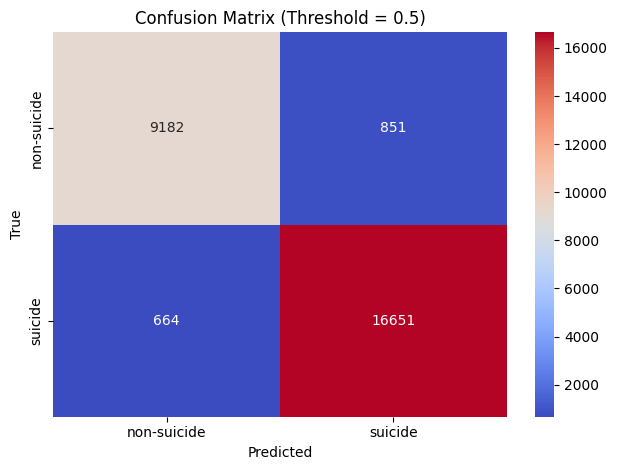


📊 Evaluation (Threshold = 0.3):
              precision    recall  f1-score   support

 non-suicide       0.96      0.87      0.91     10033
     suicide       0.93      0.98      0.95     17315

    accuracy                           0.94     27348
   macro avg       0.94      0.93      0.93     27348
weighted avg       0.94      0.94      0.94     27348

Recall: 0.9793
Precision: 0.9290
F2 Score: 0.9688


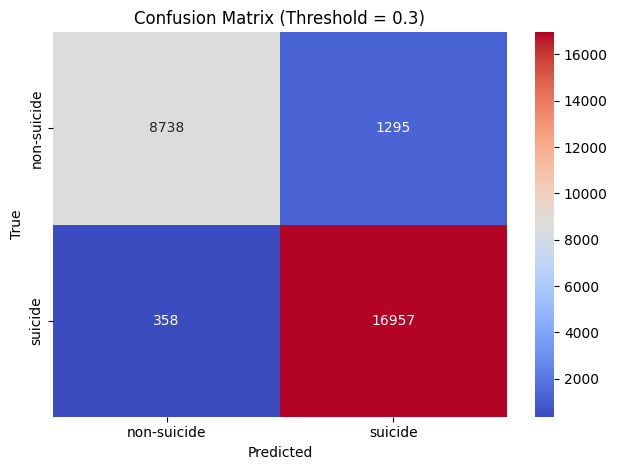

In [ ]:
# --- Imports ---
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, recall_score, precision_score, fbeta_score, confusion_matrix
from scipy.sparse import hstack, csr_matrix
import gc


# --- Gender Detection Function ---
def detect_gender(text):
    text = str(text).lower()

    male_keywords = r'\b(m|male|man|boy|he|him|his|guy|dude|gentleman|mr|sir|manly|masculine|boyish|masculinity|trans man|ftm|transmale|amab|assigned male)\b'
    female_keywords = r'\b(f|female|woman|girl|she|her|hers|lady|miss|ms|mrs|ma\'am|feminine|womanly|girly|femininity|trans woman|mtf|transfemale|afab|assigned female)\b'

    if re.search(male_keywords, text):
        return 'Male'
    elif re.search(female_keywords, text):
        return 'Female'
    return 'Unknown'

# --- Load and Filter Data ---
df = pd.read_csv('Suicide_Detection.csv', engine='python')
df = df.dropna(subset=['text', 'class'])
df['text'] = df['text'].str.replace(r'\bfiller\b', '', case=False, regex=True)

df['gender'] = df['text'].apply(detect_gender)

# Filter out unknown gender
df = df[(df['gender'] != 'Unknown')].copy()
df['label'] = df['class'].map({'non-suicide': 0, 'suicide': 1})

print(f"🧹 Filtered dataset size: {len(df)}")
print(df['gender'].value_counts())


# --- Feature Engineering: Gender ---
gender_encoded = pd.get_dummies(df['gender'], prefix='gender')

# --- USE Embedding ---
print("📦 Loading Universal Sentence Encoder...")
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def embed_text_batched(text_series, batch_size=256):
    embeddings = []
    for start in range(0, len(text_series), batch_size):
        batch = text_series.iloc[start:start+batch_size].tolist()
        embedded_batch = embed(batch).numpy()
        embeddings.append(embedded_batch)
        del embedded_batch
        gc.collect()
    return np.vstack(embeddings)

# --- Train/Test Split ---
X_train_text, X_test_text, y_train, y_test, train_df, test_df = train_test_split(
    df['text'], df['label'], df, test_size=0.2, stratify=df['label'], random_state=42
)

print("🧠 Embedding training text...")
X_train_embed = embed_text_batched(X_train_text)
print("🧠 Embedding test text...")
X_test_embed = embed_text_batched(X_test_text)

# --- Add Gender ---
X_train_meta = np.hstack([
    pd.get_dummies(train_df['gender'], prefix='gender').values
])
X_test_meta = np.hstack([
    pd.get_dummies(test_df['gender'], prefix='gender').values
])

X_train_final = np.hstack([X_train_embed, X_train_meta])
X_test_final = np.hstack([X_test_embed, X_test_meta])

# --- Train SVM ---
base_svm = LinearSVC(class_weight='balanced', random_state=42)
svm = CalibratedClassifierCV(base_svm, cv=3)
svm.fit(X_train_final, y_train)

# --- Predict Probabilities ---
y_proba = svm.predict_proba(X_test_final)[:, 1]

for threshold in [0.5, 0.3]:
    y_pred = (y_proba > threshold).astype(int)
    print(f"\n📊 Evaluation (Threshold = {threshold}):")
    print(classification_report(y_test, y_pred, target_names=['non-suicide', 'suicide']))

    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)

    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F2 Score: {f2:.4f}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=['non-suicide', 'suicide'], yticklabels=['non-suicide', 'suicide'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix (Threshold = {threshold})")
    plt.tight_layout()
    plt.show()


#***Data Analysis: Suicide By Age Group***

/tmp/ipython-input-3-3408964369.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suicide_df['age'] = suicide_df['text'].apply(extract_age)
/tmp/ipython-input-3-3408964369.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suicide_df['age_group'] = pd.cut(suicide_df['age'], bins=bins, labels=labels)
/tmp/ipython-input-3-3408964369.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for th

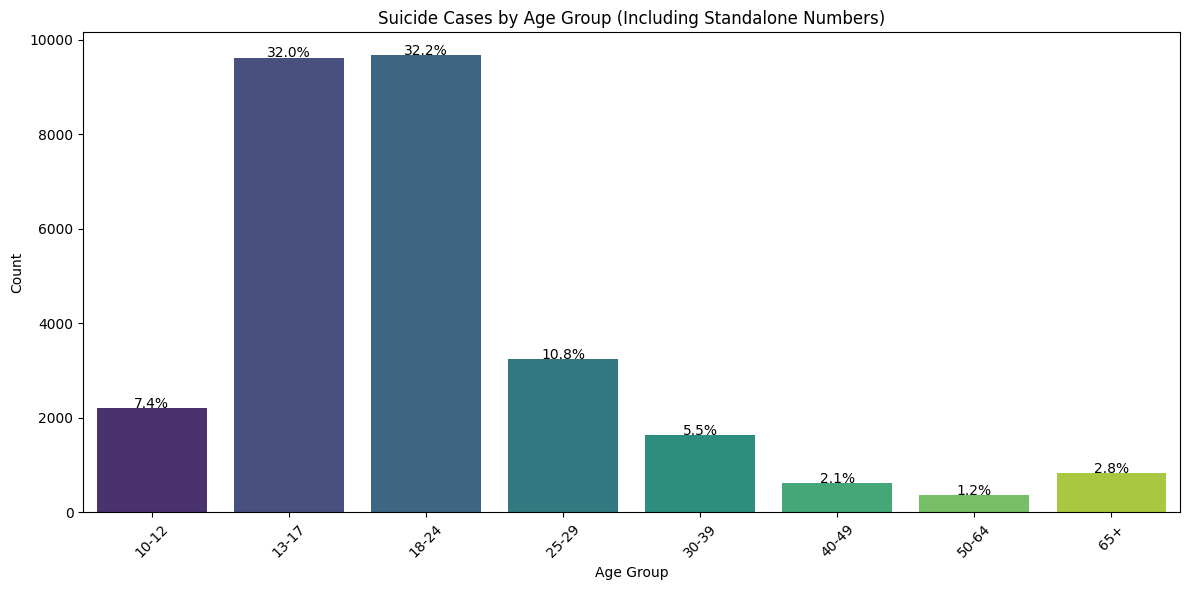


Age Mention Patterns:
contextual: 24854 cases (82.7%)
standalone: 29325 cases (97.5%)
gender_combined: 11599 cases (38.6%)

Sample Cases:
1. Contextual: Not depressed or sad but getting more comfortable with suicide day by day because I just dont enjoy ...
2. Standalone: What's the point of living for a 19 year old male who's 5"6?It hinders everything in my life and I'm...
3. Gender+Age: Tonight was the last one I could handle.A few months ago my (M22) boyfriend decide to open up our re...


In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Enhanced age extraction with standalone number support
import re
import numpy as np

def extract_age(text):
    text = str(text).lower()

    # Mapping of school year terms to approximate age
    school_year_to_age = {
        'freshman': 14,
        'sophomore': 15,
        'junior': 16,
        'senior': 17
    }
    for term, age in school_year_to_age.items():
        if term in text:
            return age

    # Contextual regex patterns
    contextual_patterns = [
        r'(?:^|\s)(?:i am|i\'m|im|me)\s*(\d{2})\s*(?:yo|y/o|years? old|yrs?)?\b',
        r'(?:^|\s)(?:turn(?:ing)?|turned)\s*(\d{2})\b',
        r'(?:^|\s)age(?:d)?\s*(\d{2})\b',
        r'\b(\d{2})\s*(?:yo|y/o|yrs?|years? old)\b',
        r'\b(?:f|female|m|male)\s*(\d{2})\b',
        r'\b(\d{2})\s*(?:f|female|m|male)\b',
        r'(?:^|\s)(?:just)?\s*(?:hit|reached|celebrated|turning)\s*(\d{2})\b',
        r'(\d{2})\s*(?:birthday|b-day|bday)\b',
        r'\b(?:i\'ll|i will|i’m going to)\s*(?:be|turn)\s*(\d{2})\b',
        r'\b(\d{2})(?=\s*in\s*(?:school|grade))'
    ]

    for pattern in contextual_patterns:
        match = re.search(pattern, text)
        if match:
            age = int(match.group(1))
            if 10 <= age <= 100:
                return age

    # Fallback pattern: check standalone two-digit numbers with context
    for match in re.finditer(r'(?<!\d)(\d{2})(?!\d)', text):
        age = int(match.group(1))
        if 10 <= age <= 100:
            start, end = match.span()
            context_window = text[max(0, start - 25):min(len(text), end + 25)]
            if any(word in context_window for word in [
                'year', 'years', 'old', 'age', 'born', 'since', 'birthday',
                'school', 'teen', 'grade', 'turn', 'turned', 'i am', 'i\'m', 'me',
                'class', 'middle', 'high', 'elementary', 'freshman', 'sophomore',
                'junior', 'senior', 'vote', 'permit', 'license', 'puberty', 'college',
                'driving', 'prom', 'graduated', 'graduate', 'next year', 'becoming'
            ]):
                return age

    return np.nan

# Load data
df = pd.read_csv('Suicide_Detection.csv', engine='python')
suicide_df = df[df['class'] == 'suicide']

# Extract ages
suicide_df['age'] = suicide_df['text'].apply(extract_age)
suicide_df = suicide_df.dropna(subset=['age'])

# Create age groups with finer granularity
bins = [10, 13, 18, 25, 30, 40, 50, 65, 100]
labels = ['10-12', '13-17', '18-24', '25-29', '30-39', '40-49', '50-64', '65+']
suicide_df['age_group'] = pd.cut(suicide_df['age'], bins=bins, labels=labels)

# Visualization
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=suicide_df, x='age_group',
                  order=labels, palette='viridis')

# Add percentages
total = len(suicide_df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 3,
           f'{height/total:.1%}',
           ha='center')

plt.title('Suicide Cases by Age Group (Including Standalone Numbers)')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Age mention analysis
def analyze_age_mentions(df):
    results = {
        'contextual': 0,  # Explicit age context
        'standalone': 0,  # Just numbers
        'gender_combined': 0  # Age with gender markers
    }

    for text in df['text']:
        text = str(text).lower()
        if re.search(r'(?:age|old|year)', text):
            results['contextual'] += 1
        if re.search(r'(?<!\d)\d{2}(?!\d)', text):  # Standalone 2-digit numbers
            results['standalone'] += 1
        if re.search(r'(?:f|m|male|female)\s*\d{2}', text):
            results['gender_combined'] += 1

    return results

mention_stats = analyze_age_mentions(suicide_df)
print("\nAge Mention Patterns:")
for k, v in mention_stats.items():
    print(f"{k}: {v} cases ({v/len(suicide_df):.1%})")

# Sample cases with different mention types
print("\nSample Cases:")
try:
    print("1. Contextual:", next(t for t in suicide_df['text'] if "i'm 25 years old" in t.lower())[:100] + "...")
except StopIteration:
    print("1. Contextual: No sample found for 'i'm 25 years old'")

try:
    print("2. Standalone:", next(t for t in suicide_df['text'] if re.search(r'(?<!\d)19(?!\d)', t))[:100] + "...")
except StopIteration:
    print("2. Standalone: No sample found for standalone 19")

try:
    print("3. Gender+Age:", next(t for t in suicide_df['text'] if re.search(r'f\s?23', t.lower()))[:100] + "...")
except StopIteration:
    print("3. Gender+Age: No sample found for 'f 23'")

/tmp/ipython-input-4-2425468508.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suicide_df['age'] = suicide_df['text'].apply(extract_age)
/tmp/ipython-input-4-2425468508.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suicide_df['age_group'] = pd.cut(suicide_df['age'], bins=bins, labels=labels)
/tmp/ipython-input-4-2425468508.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for th

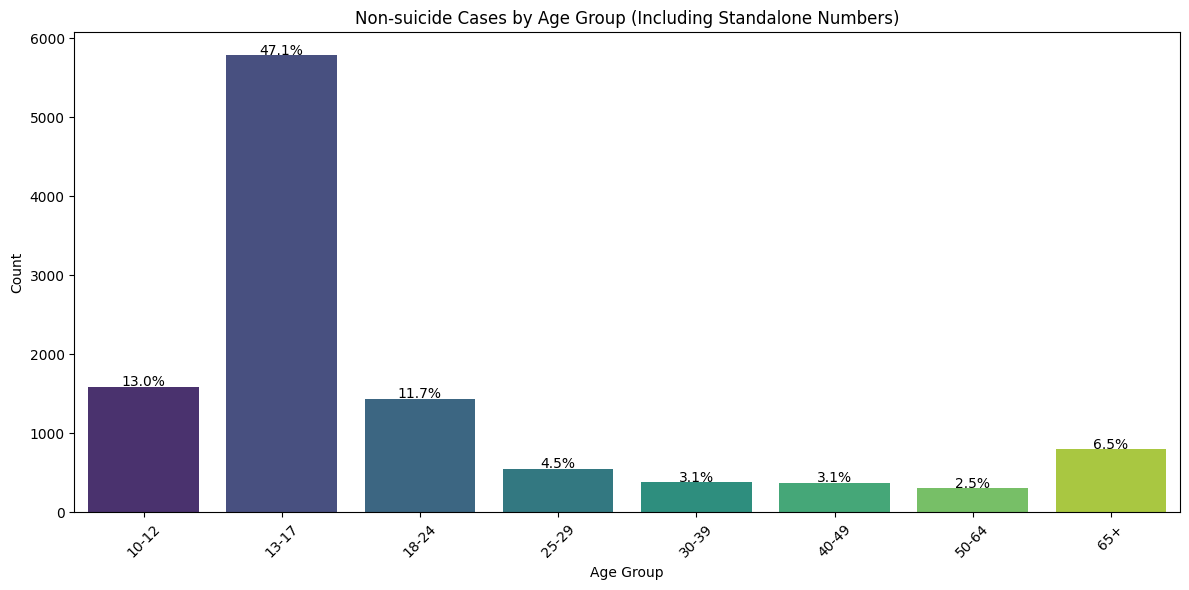


Age Mention Patterns:
contextual: 6619 cases (53.9%)
standalone: 11816 cases (96.2%)
gender_combined: 2828 cases (23.0%)

Sample Cases:
1. Contextual: No sample found for 'i'm 25 years old'
2. Standalone: To the actual dunce who may or may not have given me Covid-19: Fuck you. Eat shit and die. No amount...
3. Gender+Age: Happy birthday to my depressing self 23rd December is my birthday. I'm turning 14. Another year clos...


In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Enhanced age extraction with standalone number support
import re
import numpy as np

def extract_age(text):
    text = str(text).lower()

    # Mapping of school year terms to approximate age
    school_year_to_age = {
        'freshman': 14,
        'sophomore': 15,
        'junior': 16,
        'senior': 17
    }
    for term, age in school_year_to_age.items():
        if term in text:
            return age

    # Contextual regex patterns
    contextual_patterns = [
        r'(?:^|\s)(?:i am|i\'m|im|me)\s*(\d{2})\s*(?:yo|y/o|years? old|yrs?)?\b',
        r'(?:^|\s)(?:turn(?:ing)?|turned)\s*(\d{2})\b',
        r'(?:^|\s)age(?:d)?\s*(\d{2})\b',
        r'\b(\d{2})\s*(?:yo|y/o|yrs?|years? old)\b',
        r'\b(?:f|female|m|male)\s*(\d{2})\b',
        r'\b(\d{2})\s*(?:f|female|m|male)\b',
        r'(?:^|\s)(?:just)?\s*(?:hit|reached|celebrated|turning)\s*(\d{2})\b',
        r'(\d{2})\s*(?:birthday|b-day|bday)\b',
        r'\b(?:i\'ll|i will|i’m going to)\s*(?:be|turn)\s*(\d{2})\b',
        r'\b(\d{2})(?=\s*in\s*(?:school|grade))'
    ]

    for pattern in contextual_patterns:
        match = re.search(pattern, text)
        if match:
            age = int(match.group(1))
            if 10 <= age <= 100:
                return age

    # Fallback pattern: check standalone two-digit numbers with context
    for match in re.finditer(r'(?<!\d)(\d{2})(?!\d)', text):
        age = int(match.group(1))
        if 10 <= age <= 100:
            start, end = match.span()
            context_window = text[max(0, start - 25):min(len(text), end + 25)]
            if any(word in context_window for word in [
                'year', 'years', 'old', 'age', 'born', 'since', 'birthday',
                'school', 'teen', 'grade', 'turn', 'turned', 'i am', 'i\'m', 'me',
                'class', 'middle', 'high', 'elementary', 'freshman', 'sophomore',
                'junior', 'senior', 'vote', 'permit', 'license', 'puberty', 'college',
                'driving', 'prom', 'graduated', 'graduate', 'next year', 'becoming'
            ]):
                return age

    return np.nan

# Load data
df = pd.read_csv('Suicide_Detection.csv', engine='python')
suicide_df = df[df['class'] == 'non-suicide']

# Extract ages
suicide_df['age'] = suicide_df['text'].apply(extract_age)
suicide_df = suicide_df.dropna(subset=['age'])

# Create age groups with finer granularity
bins = [10, 13, 18, 25, 30, 40, 50, 65, 100]
labels = ['10-12', '13-17', '18-24', '25-29', '30-39', '40-49', '50-64', '65+']
suicide_df['age_group'] = pd.cut(suicide_df['age'], bins=bins, labels=labels)

# Visualization
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=suicide_df, x='age_group',
                  order=labels, palette='viridis')

# Add percentages
total = len(suicide_df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 3,
           f'{height/total:.1%}',
           ha='center')

plt.title('Non-suicide Cases by Age Group (Including Standalone Numbers)')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Age mention analysis
def analyze_age_mentions(df):
    results = {
        'contextual': 0,  # Explicit age context
        'standalone': 0,  # Just numbers
        'gender_combined': 0  # Age with gender markers
    }

    for text in df['text']:
        text = str(text).lower()
        if re.search(r'(?:age|old|year)', text):
            results['contextual'] += 1
        if re.search(r'(?<!\d)\d{2}(?!\d)', text):  # Standalone 2-digit numbers
            results['standalone'] += 1
        if re.search(r'(?:f|m|male|female)\s*\d{2}', text):
            results['gender_combined'] += 1

    return results

mention_stats = analyze_age_mentions(suicide_df)
print("\nAge Mention Patterns:")
for k, v in mention_stats.items():
    print(f"{k}: {v} cases ({v/len(suicide_df):.1%})")

# Sample cases with different mention types
print("\nSample Cases:")
try:
    print("1. Contextual:", next(t for t in suicide_df['text'] if "i'm 25 years old" in t.lower())[:100] + "...")
except StopIteration:
    print("1. Contextual: No sample found for 'i'm 25 years old'")

try:
    print("2. Standalone:", next(t for t in suicide_df['text'] if re.search(r'(?<!\d)19(?!\d)', t))[:100] + "...")
except StopIteration:
    print("2. Standalone: No sample found for standalone 19")

try:
    print("3. Gender+Age:", next(t for t in suicide_df['text'] if re.search(r'f\s?23', t.lower()))[:100] + "...")
except StopIteration:
    print("3. Gender+Age: No sample found for 'f 23'")

/tmp/ipython-input-5-1547246855.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)
/tmp/ipython-input-5-1547246855.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='age_group',


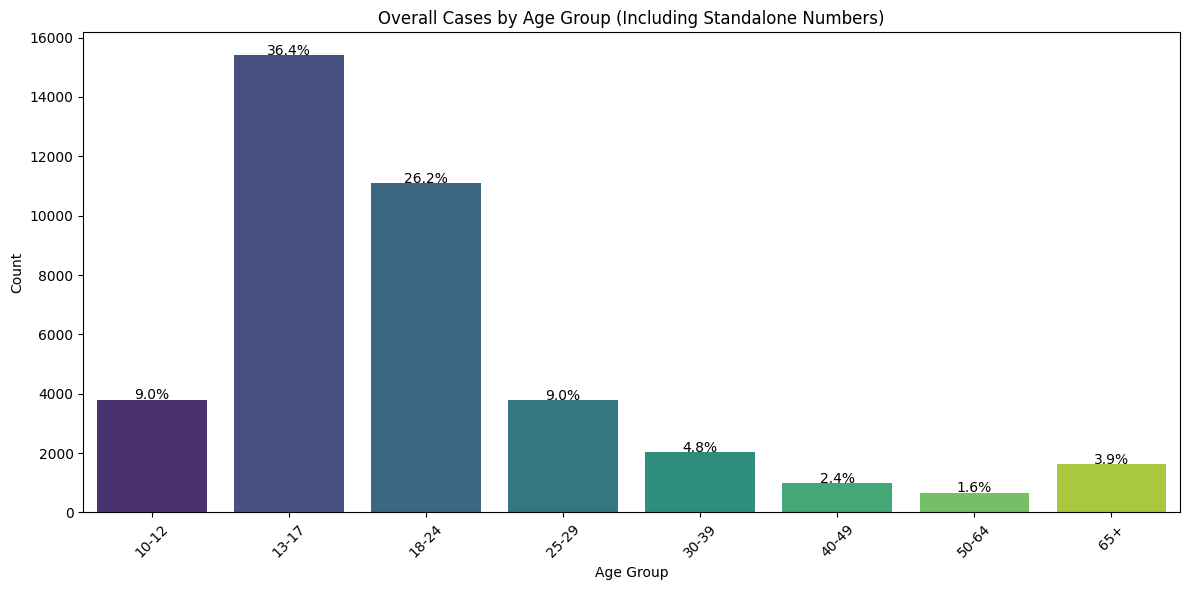


Age Mention Patterns:
contextual: 31473 cases (74.3%)
standalone: 41141 cases (97.1%)
gender_combined: 14427 cases (34.1%)

Sample Cases:
1. Contextual: Not depressed or sad but getting more comfortable with suicide day by day because I just dont enjoy ...
2. Standalone: What's the point of living for a 19 year old male who's 5"6?It hinders everything in my life and I'm...
3. Gender+Age: Tonight was the last one I could handle.A few months ago my (M22) boyfriend decide to open up our re...


In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Enhanced age extraction with standalone number support
import re
import numpy as np

def extract_age(text):
    text = str(text).lower()

    # Mapping of school year terms to approximate age
    school_year_to_age = {
        'freshman': 14,
        'sophomore': 15,
        'junior': 16,
        'senior': 17
    }
    for term, age in school_year_to_age.items():
        if term in text:
            return age

    # Contextual regex patterns
    contextual_patterns = [
        r'(?:^|\s)(?:i am|i\'m|im|me)\s*(\d{2})\s*(?:yo|y/o|years? old|yrs?)?\b',
        r'(?:^|\s)(?:turn(?:ing)?|turned)\s*(\d{2})\b',
        r'(?:^|\s)age(?:d)?\s*(\d{2})\b',
        r'\b(\d{2})\s*(?:yo|y/o|yrs?|years? old)\b',
        r'\b(?:f|female|m|male)\s*(\d{2})\b',
        r'\b(\d{2})\s*(?:f|female|m|male)\b',
        r'(?:^|\s)(?:just)?\s*(?:hit|reached|celebrated|turning)\s*(\d{2})\b',
        r'(\d{2})\s*(?:birthday|b-day|bday)\b',
        r'\b(?:i\'ll|i will|i’m going to)\s*(?:be|turn)\s*(\d{2})\b',
        r'\b(\d{2})(?=\s*in\s*(?:school|grade))'
    ]

    for pattern in contextual_patterns:
        match = re.search(pattern, text)
        if match:
            age = int(match.group(1))
            if 10 <= age <= 100:
                return age

    # Fallback pattern: check standalone two-digit numbers with context
    for match in re.finditer(r'(?<!\d)(\d{2})(?!\d)', text):
        age = int(match.group(1))
        if 10 <= age <= 100:
            start, end = match.span()
            context_window = text[max(0, start - 25):min(len(text), end + 25)]
            if any(word in context_window for word in [
                'year', 'years', 'old', 'age', 'born', 'since', 'birthday',
                'school', 'teen', 'grade', 'turn', 'turned', 'i am', 'i\'m', 'me',
                'class', 'middle', 'high', 'elementary', 'freshman', 'sophomore',
                'junior', 'senior', 'vote', 'permit', 'license', 'puberty', 'college',
                'driving', 'prom', 'graduated', 'graduate', 'next year', 'becoming'
            ]):
                return age

    return np.nan



# Load data
df = pd.read_csv('Suicide_Detection.csv', engine='python')

# Extract ages
df['age'] = df['text'].apply(extract_age)
df = df.dropna(subset=['age'])

# Create age groups with finer granularity
bins = [10, 13, 18, 25, 30, 40, 50, 65, 100]
labels = ['10-12', '13-17', '18-24', '25-29', '30-39', '40-49', '50-64', '65+']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)

# Visualization
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df, x='age_group',
                  order=labels, palette='viridis')

# Add percentages
total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 3,
           f'{height/total:.1%}',
           ha='center')

plt.title('Overall Cases by Age Group (Including Standalone Numbers)')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Age mention analysis
def analyze_age_mentions(df):
    results = {
        'contextual': 0,  # Explicit age context
        'standalone': 0,  # Just numbers
        'gender_combined': 0  # Age with gender markers
    }

    for text in df['text']:
        text = str(text).lower()
        if re.search(r'(?:age|old|year)', text):
            results['contextual'] += 1
        if re.search(r'(?<!\d)\d{2}(?!\d)', text):  # Standalone 2-digit numbers
            results['standalone'] += 1
        if re.search(r'(?:f|m|male|female)\s*\d{2}', text):
            results['gender_combined'] += 1

    return results

mention_stats = analyze_age_mentions(df)
print("\nAge Mention Patterns:")
for k, v in mention_stats.items():
    print(f"{k}: {v} cases ({v/len(df):.1%})")

# Sample cases with different mention types
print("\nSample Cases:")
try:
    print("1. Contextual:", next(t for t in df['text'] if "i'm 25 years old" in t.lower())[:100] + "...")
except StopIteration:
    print("1. Contextual: No sample found for 'i'm 25 years old'")

try:
    print("2. Standalone:", next(t for t in df['text'] if re.search(r'(?<!\d)19(?!\d)', t))[:100] + "...")
except StopIteration:
    print("2. Standalone: No sample found for standalone 19")

try:
    print("3. Gender+Age:", next(t for t in df['text'] if re.search(r'f\s?23', t.lower()))[:100] + "...")
except StopIteration:
    print("3. Gender+Age: No sample found for 'f 23'")

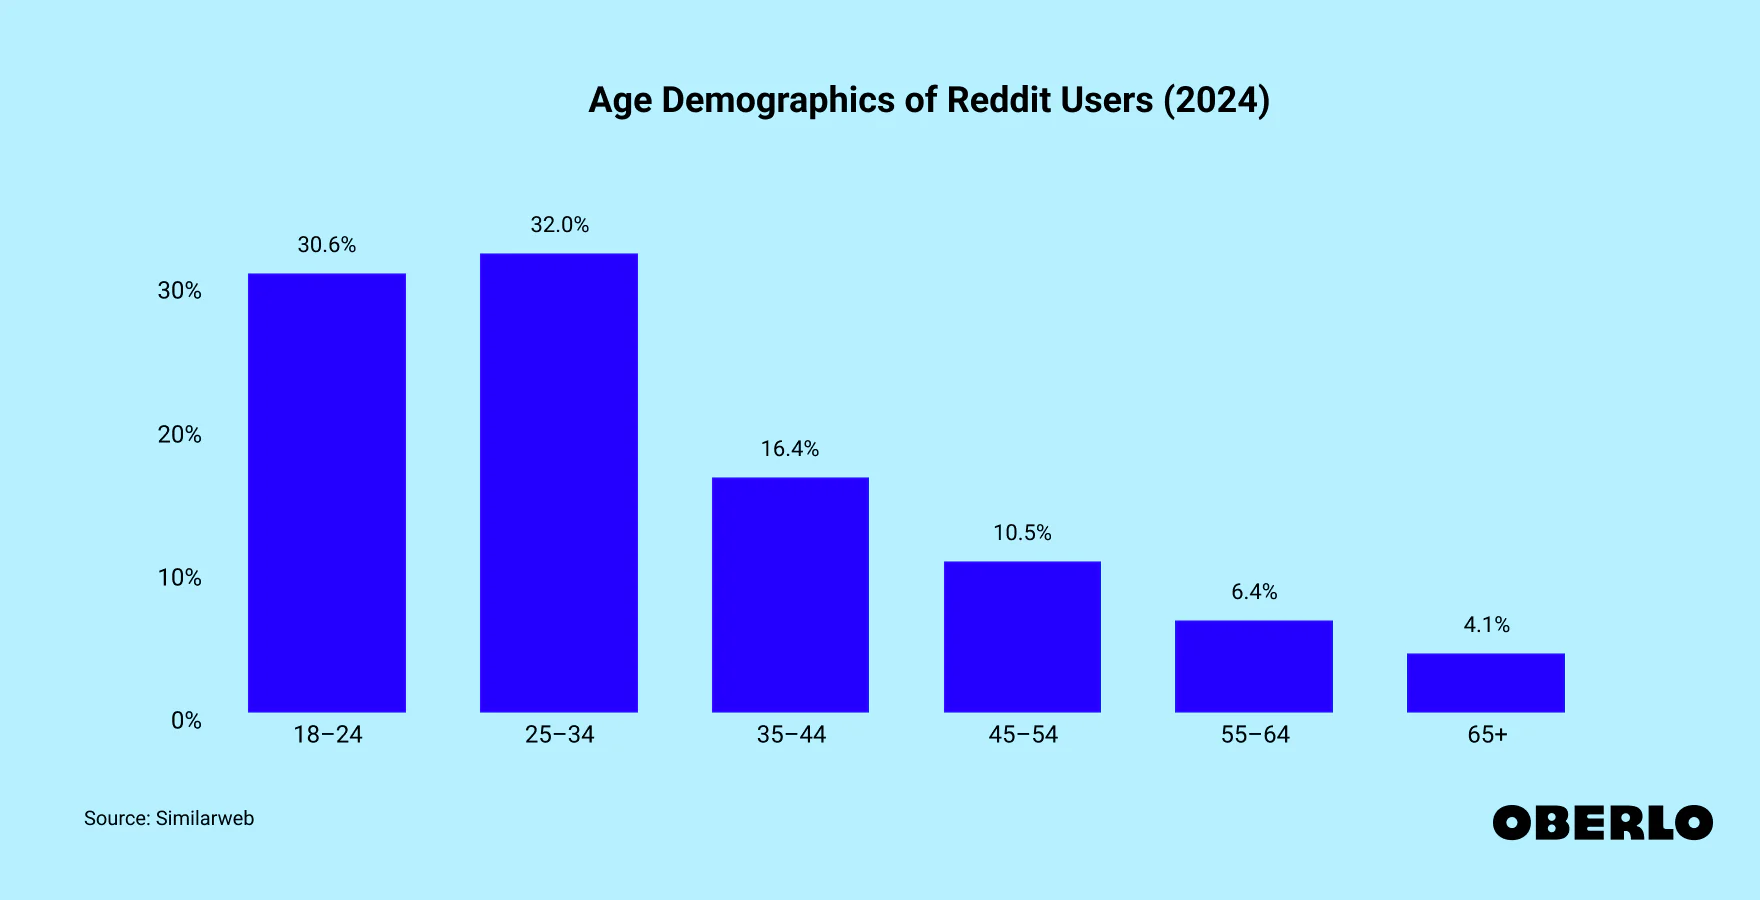

# ***Data Analysis: Suicide By Gender***

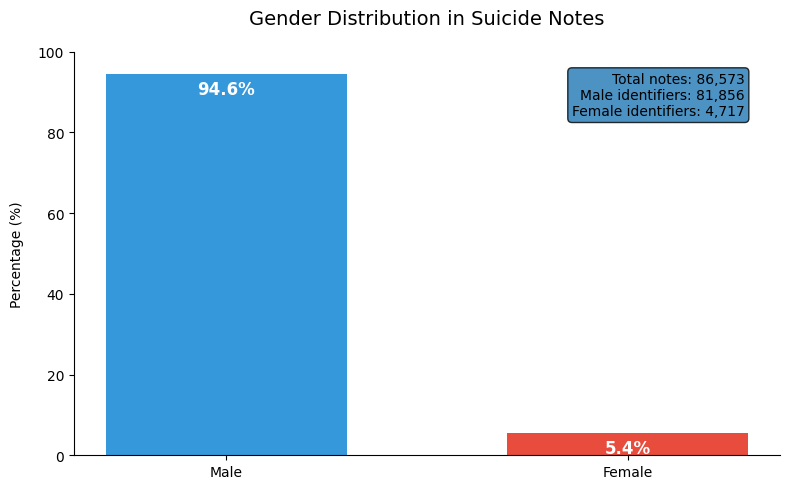

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('Suicide_Detection.csv', engine='python')
suicide_df = df[df['class'] == 'suicide'].copy()

# --- Gender Detection Function ---
def detect_gender(text):
    text = str(text).lower()

    male_keywords = r'\b(m|male|man|boy|he|him|his|guy|dude|gentleman|mr|sir|manly|masculine|boyish|masculinity|trans man|ftm|transmale|amab|assigned male)\b'
    female_keywords = r'\b(f|female|woman|girl|she|her|hers|lady|miss|ms|mrs|ma\'am|feminine|womanly|girly|femininity|trans woman|mtf|transfemale|afab|assigned female)\b'

    if re.search(male_keywords, text):
        return 'Male'
    elif re.search(female_keywords, text):
        return 'Female'
    return 'Unknown'

# Apply gender detection
suicide_df['gender'] = suicide_df['text'].apply(detect_gender)
suicide_df = suicide_df[(suicide_df['gender'] != 'Unknown')].copy()

# Calculate percentages
gender_counts = suicide_df['gender'].value_counts()
percentages = (gender_counts / len(suicide_df)) * 100

# Clean visualization
plt.figure(figsize=(8, 5))
bars = plt.bar(percentages.index, percentages.values,
               color=['#3498db', '#e74c3c', '#95a5a6'],  # Blue, Red, Gray
               width=0.6)

# Add exact percentages on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height-5,
             f'{height:.1f}%',
             ha='center', color='white', fontweight='bold', fontsize=12)

plt.title('Gender Distribution in Suicide Notes', pad=20, fontsize=14)
plt.ylabel('Percentage (%)', labelpad=10)
plt.ylim(0, 100)
plt.gca().spines[['top', 'right']].set_visible(False)

# Add sample size annotation
plt.annotate(f'Total notes: {len(suicide_df):,}\n'
            f'Male identifiers: {gender_counts.get("Male", 0):,}\n'
            f'Female identifiers: {gender_counts.get("Female", 0):,}',
            xy=(0.95, 0.95), xycoords='axes fraction',
            ha='right', va='top', bbox=dict(boxstyle='round', alpha=0.8))

plt.tight_layout()
plt.show()

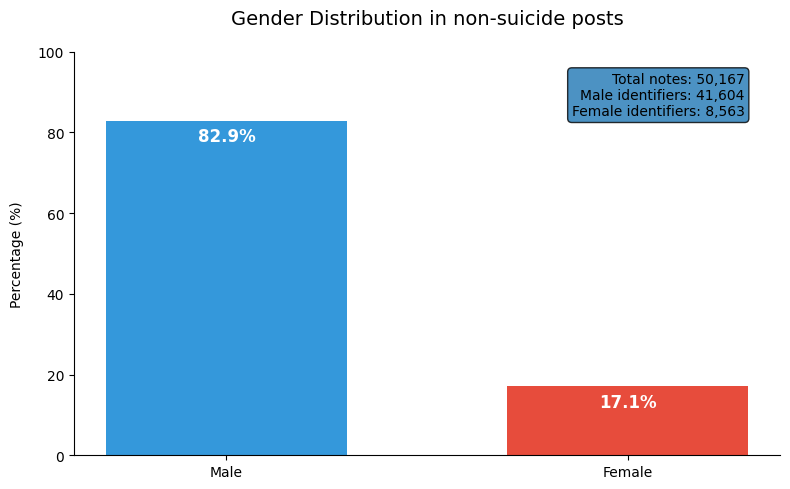

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('Suicide_Detection.csv', engine='python')
suicide_df = df[df['class'] == 'non-suicide'].copy()

# --- Gender Detection Function ---
def detect_gender(text):
    text = str(text).lower()

    male_keywords = r'\b(m|male|man|boy|he|him|his|guy|dude|gentleman|mr|sir|manly|masculine|boyish|masculinity|trans man|ftm|transmale|amab|assigned male)\b'
    female_keywords = r'\b(f|female|woman|girl|she|her|hers|lady|miss|ms|mrs|ma\'am|feminine|womanly|girly|femininity|trans woman|mtf|transfemale|afab|assigned female)\b'

    if re.search(male_keywords, text):
        return 'Male'
    elif re.search(female_keywords, text):
        return 'Female'
    return 'Unknown'

# Apply gender detection
suicide_df['gender'] = suicide_df['text'].apply(detect_gender)
suicide_df = suicide_df[(suicide_df['gender'] != 'Unknown')].copy()
# Calculate percentages
gender_counts = suicide_df['gender'].value_counts()
percentages = (gender_counts / len(suicide_df)) * 100

# Clean visualization
plt.figure(figsize=(8, 5))
bars = plt.bar(percentages.index, percentages.values,
               color=['#3498db', '#e74c3c', '#95a5a6'],  # Blue, Red, Gray
               width=0.6)

# Add exact percentages on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height-5,
             f'{height:.1f}%',
             ha='center', color='white', fontweight='bold', fontsize=12)

plt.title('Gender Distribution in non-suicide posts', pad=20, fontsize=14)
plt.ylabel('Percentage (%)', labelpad=10)
plt.ylim(0, 100)
plt.gca().spines[['top', 'right']].set_visible(False)

# Add sample size annotation
plt.annotate(f'Total notes: {len(suicide_df):,}\n'
            f'Male identifiers: {gender_counts.get("Male", 0):,}\n'
            f'Female identifiers: {gender_counts.get("Female", 0):,}',
            xy=(0.95, 0.95), xycoords='axes fraction',
            ha='right', va='top', bbox=dict(boxstyle='round', alpha=0.8))

plt.tight_layout()
plt.show()

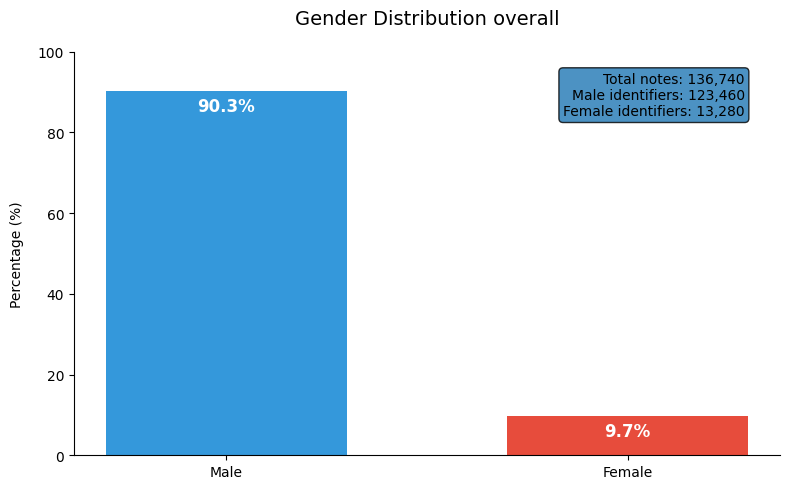

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('Suicide_Detection.csv', engine='python')

# Simplified gender detection (only looks for explicit mentions)
# --- Gender Detection Function ---
def detect_gender(text):
    text = str(text).lower()

    male_keywords = r'\b(m|male|man|boy|he|him|his|guy|dude|gentleman|mr|sir|manly|masculine|boyish|masculinity|trans man|ftm|transmale|amab|assigned male)\b'
    female_keywords = r'\b(f|female|woman|girl|she|her|hers|lady|miss|ms|mrs|ma\'am|feminine|womanly|girly|femininity|trans woman|mtf|transfemale|afab|assigned female)\b'

    if re.search(male_keywords, text):
        return 'Male'
    elif re.search(female_keywords, text):
        return 'Female'
    return 'Unknown'

# Apply gender detection
df['gender'] = df['text'].apply(detect_gender)
df = df[(df['gender'] != 'Unknown')].copy()
# Calculate percentages
gender_counts = df['gender'].value_counts()
percentages = (gender_counts / len(df)) * 100

# Clean visualization
plt.figure(figsize=(8, 5))
bars = plt.bar(percentages.index, percentages.values,
               color=['#3498db', '#e74c3c', '#95a5a6'],  # Blue, Red, Gray
               width=0.6)

# Add exact percentages on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height-5,
             f'{height:.1f}%',
             ha='center', color='white', fontweight='bold', fontsize=12)

plt.title('Gender Distribution overall', pad=20, fontsize=14)
plt.ylabel('Percentage (%)', labelpad=10)
plt.ylim(0, 100)
plt.gca().spines[['top', 'right']].set_visible(False)

# Add sample size annotation
plt.annotate(f'Total notes: {len(df):,}\n'
            f'Male identifiers: {gender_counts.get("Male", 0):,}\n'
            f'Female identifiers: {gender_counts.get("Female", 0):,}',
            xy=(0.95, 0.95), xycoords='axes fraction',
            ha='right', va='top', bbox=dict(boxstyle='round', alpha=0.8))

plt.tight_layout()
plt.show()

# ***Data Analysis: KMeans Clustering***


📊 Posts per Cluster:
cluster
0    12656
1     7344
Name: count, dtype: int64

🧠 Silhouette Score (higher = better separation): 0.0575

🔍 Class distribution within each cluster:
class    non-suicide   suicide
cluster                       
0           0.736252  0.263748
1           0.111247  0.888753


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


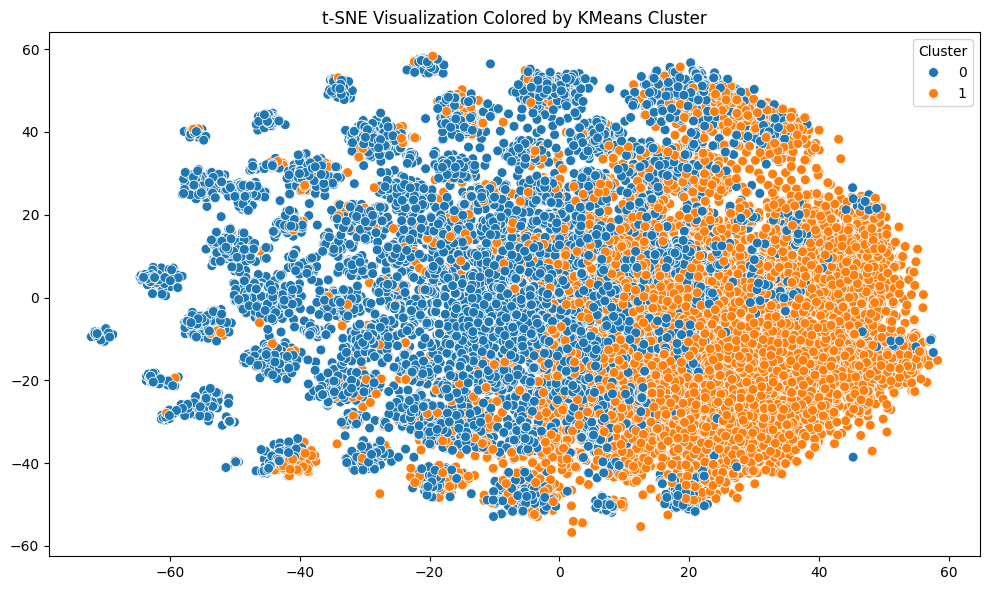

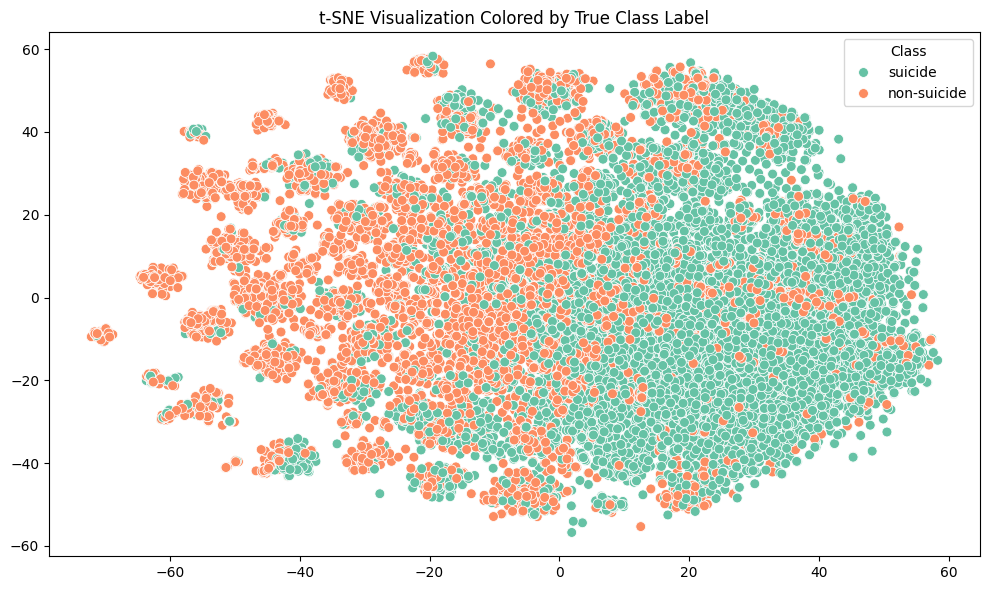


✅ Cluster Purity (majority class % per cluster):
Cluster 0: 73.63% pure
Cluster 1: 88.88% pure

📝 Sample post from each cluster:

--- Cluster 0 Sample ---
Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice and lied to me so much that I have decided to refuse to go back to her. As of a few days ago, she began threatening suicide. I have tirelessly spent these paat few days talking her out of it and she keeps hesitating because she wants to believe I'll come back. I know a lot of people will threaten this in order to get their way, but what happens if she really does? What do I do and how am I supposed to handle her death on my hands? I still love my wife but I cannot deal with getting cheated on again and constantly feeling insecure. I'm worried today may be the day she does it and I hope so much it doesn't happen.


--- Cluster 0 Sample ---
Am I weird I don't get affected by compliments if it's coming from someone I know irl but I feel real

In [ ]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

# --- Load data ---
df = pd.read_csv('Suicide_Detection.csv', nrows=20000, engine='python')
df = df.dropna(subset=['text', 'class'])
df = df[df['class'].isin(['suicide', 'non-suicide'])]  # Ensure only the 2 classes
df['text'] = df['text'].str.replace(r'\bfiller\b', '', case=False, regex=True)
texts = df['text'].values

# --- TF-IDF ---
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_tfidf = tfidf.fit_transform(texts)

# --- SVD Dimensionality Reduction ---
svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

# --- KMeans ---
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
df['cluster'] = kmeans.fit_predict(X_reduced)

# --- Cluster Distribution ---
print("\n📊 Posts per Cluster:")
print(df['cluster'].value_counts().sort_index())

# --- Silhouette Score ---
sil_score = silhouette_score(X_reduced, df['cluster'])
print(f"\n🧠 Silhouette Score (higher = better separation): {sil_score:.4f}")

# --- Class vs Cluster Crosstab ---
print("\n🔍 Class distribution within each cluster:")
print(pd.crosstab(df['cluster'], df['class'], normalize='index'))

# --- t-SNE Embedding ---
tsne = TSNE(n_components=2, perplexity=40, learning_rate=200, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_reduced)

# --- Visualization 1: Clustered t-SNE ---
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=df['cluster'], palette='tab10', s=50)
plt.title("t-SNE Visualization Colored by KMeans Cluster")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# --- Visualization 2: True Class t-SNE ---
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=df['class'], palette='Set2', s=50)
plt.title("t-SNE Visualization Colored by True Class Label")
plt.legend(title="Class")
plt.tight_layout()
plt.show()

# --- Optional: Purity Check (dominant class in each cluster) ---
print("\n✅ Cluster Purity (majority class % per cluster):")
crosstab = pd.crosstab(df['cluster'], df['class'])
purity = crosstab.max(axis=1) / crosstab.sum(axis=1)
for cluster_id, score in purity.items():
    print(f"Cluster {cluster_id}: {score:.2%} pure")

# --- Sample Posts per Cluster ---
print("\n📝 Sample post from each cluster:")
for cluster_id in sorted(df['cluster'].unique()):
    for i in range(3):
      sample_text = df[df['cluster'] == cluster_id]['text'].iloc[i]
      print(f"\n--- Cluster {cluster_id} Sample ---\n{sample_text}\n")

# ***Data Analysis: Class counts***

# ***Data Analysis: Word Cloud***

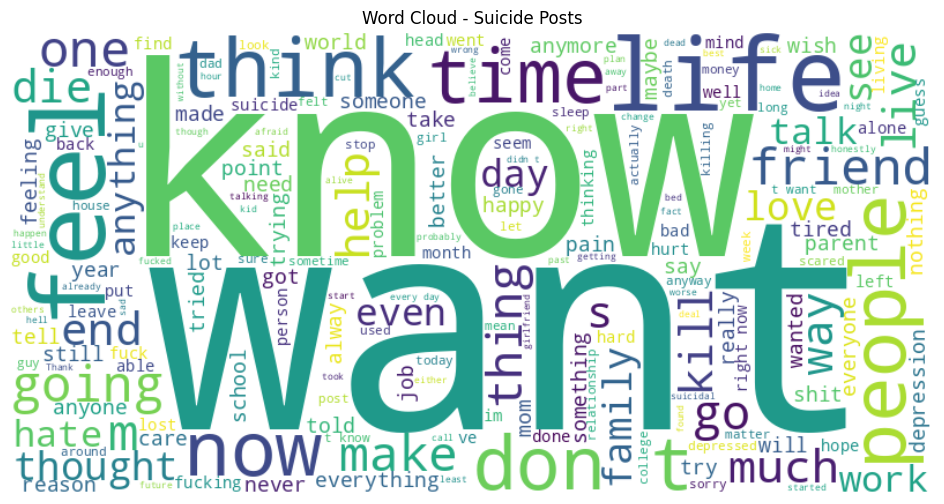

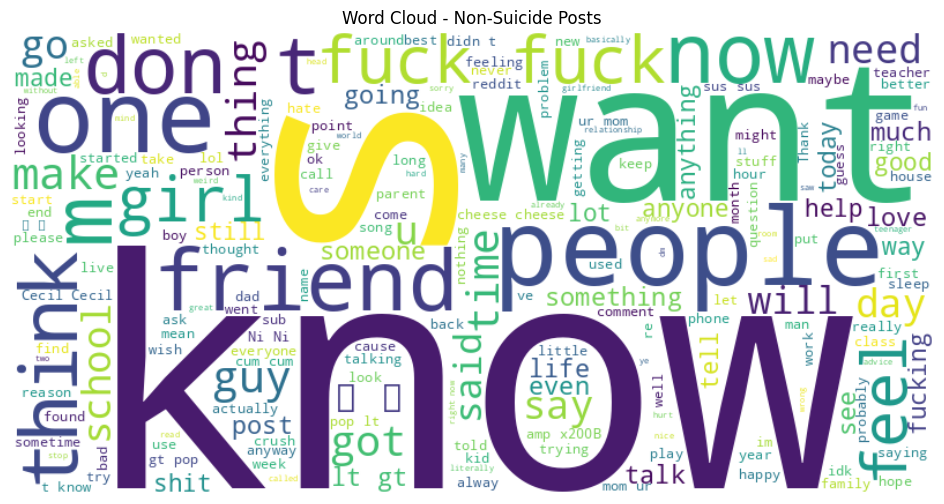

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv('Suicide_Detection.csv', engine='python')
df['text'] = df['text'].str.replace(r'\bfiller\b', '', case=False, regex=True)

# Optional: filter for suicide or non-suicide texts
suicide_text = ' '.join(df[df['class'] == 'suicide']['text'].dropna().tolist())
non_suicide_text = ' '.join(df[df['class'] == 'non-suicide']['text'].dropna().tolist())

# Create the word cloud
suicide_wc = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(suicide_text)
non_suicide_wc = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(non_suicide_text)

# Display suicide word cloud
plt.figure(figsize=(12, 6))
plt.imshow(suicide_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Suicide Posts')
plt.show()

# Display non-suicide word cloud
plt.figure(figsize=(12, 6))
plt.imshow(non_suicide_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Non-Suicide Posts')
plt.show()